In [1]:
import os
import sys
import random
import math
import re
import time
import numpy as np
import cv2
import matplotlib
import matplotlib.pyplot as plt
# Root directory of the project
ROOT_DIR = os.path.abspath("/lfs/jonas/maskrcnn/")

# Import Mask RCNN
sys.path.append(ROOT_DIR)  # To find local version of the library
from mrcnn.config import Config
from mrcnn import utils
import mrcnn.model as modellib
from mrcnn import visualize
from mrcnn.model import log

%matplotlib inline 

# Directory to save logs and trained model
MODEL_DIR = os.path.join(ROOT_DIR, "logs")

#Local path to trained weights file
COCO_MODEL_PATH = os.path.join(ROOT_DIR, "mask_rcnn_coco.h5")
# Download COCO trained weights from Releases if needed
if not os.path.exists(COCO_MODEL_PATH):
    utils.download_trained_weights(COCO_MODEL_PATH)

In [2]:
import warnings
warnings.filterwarnings("ignore", category=np.VisibleDeprecationWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

## Configurations

In [3]:
class SatsConfig(Config):
    # Give the configuration a recognizable name
    NAME = "sats"

    # Train on 1 GPU and 8 images per GPU. We can put multiple images on each
    # GPU because the images are small. Batch size is 8 (GPUs * images/GPU).
    GPU_COUNT = 1
    IMAGES_PER_GPU = 16

    # Number of classes (including background)
    NUM_CLASSES = 1 + 1  # background + 3 shapes

    # Use small images for faster training. Set the limits of the small side
    # the large side, and that determines the image shape.
    IMAGE_MIN_DIM = 128
    IMAGE_MAX_DIM = 128

    # Use smaller anchors because our image and objects are small
    RPN_ANCHOR_SCALES = (4, 8, 16, 32, 64)  # anchor side in pixels

    # Reduce training ROIs per image because the images are small and have
    # few objects. Aim to allow ROI sampling to pick 33% positive ROIs.
    TRAIN_ROIS_PER_IMAGE = 64

    # Use a small epoch since the data is simple
    STEPS_PER_EPOCH = 500

    # use small validation steps since the epoch is small
    VALIDATION_STEPS = 10
    
    USE_MINI_MASK = False
    MINI_MASK_SHAPE = (128,128)
    
config = SatsConfig()
#config.display()

In [4]:
def get_ax(rows=1, cols=1, size=8):
    """Return a Matplotlib Axes array to be used in
    all visualizations in the notebook. Provide a
    central point to control graph sizes.
    
    Change the default size attribute to control the size
    of rendered images
    """
    _, ax = plt.subplots(rows, cols, figsize=(size*cols, size*rows))
    return ax

In [5]:
image_path = '/data/spacenet/bldg/data/train/MUL/'
geojson_path = '/data/spacenet/bldg/data/train/geojson/'
valid_image_path = '/data/spacenet/bldg/data/validation/MUL/'
valid_geojson_path = '/data/spacenet/bldg/data/validation/geojson/'

In [6]:
class SatDataset(utils.Dataset):
    def scale_coord(self, geom, image):

        scale_x = abs(geom[0] - image.bounds[0]) * abs(image.width / (image.bounds[0] - image.bounds[2]))
        scale_y = abs(geom[1] - image.bounds[3]) * abs(image.height / (image.bounds[1] - image.bounds[3]))


        return scale_x, scale_y
    def preprocessing_image_ms(self, x, mean, std):
        # loop over image bands
        for idx, mean_value in enumerate(mean):
            x[..., idx] -= mean_value
            x[..., idx] /= std[idx]
        return x

    def load_sats(self, image_path, geojson_path):
        from glob import glob
        
        self.add_class("sat", 1, "building")
        
        image_glob = glob(image_path + '*.tif')
        for idx, path in enumerate(image_glob):
            self.add_image("sat", image_id=idx, path=path,
                          jsonPath=geojson_path)
    
    def load_image(self, image_id):
        """Load the specified image and return a [H,W,3] Numpy array.
        """
        from skimage.io import imread
        # Load image
        input_path = self.image_info[image_id]['path']
        image = np.array(imread(input_path), dtype=float)
        
        bands = [4,2,1]
        
        image = image[:,:,bands]
        
        mean_std_data = np.loadtxt('image_mean_std.txt', delimiter=',')
        mean_std_data = mean_std_data[bands,:]
        image = self.preprocessing_image_ms(image, mean_std_data[:,0], mean_std_data[:,1])
        
        return image        
    
    def load_orig_image(self, image_id):
        """Load the specified image (without stand.) and return a [H,W,3] Numpy array.
        """
        from skimage.io import imread
        # Load image
        input_path = self.image_info[image_id]['path']
        image = np.array(imread(input_path), dtype=float)
        
        bands = [4,2,1]
        
        image = image[:,:,bands]
        
        image = (image * 255) / image.max()
        
        return image        
    def load_mask(self, image_id):
        import cv2
        import os
        import json
        import rasterio as rio
        import numpy as np
        import scipy.ndimage as ndi
        
        geojson_path = self.image_info[image_id]['jsonPath']
        input_path = self.image_info[image_id]['path']
        
        image_filename = os.path.split(input_path)[-1]
        json_filename = 'buildings' + image_filename[14:-4] + '.geojson'
        geojson_file = os.path.join(geojson_path, json_filename)
    
        #Load JSON
        with open(geojson_file, 'r') as f:
            geo_json = json.load(f)
    
        #Open image to get scale
        image = rio.open(input_path)
        image_shape = image.shape
        #Load and scale all the polygons (buildings)
        polys = []

        for feature in geo_json['features']:
            scaled_coordSet = []
            if feature['geometry']['type'] == 'Polygon':
                for coordinatesSet in feature['geometry']['coordinates']:
                    for coordinates in coordinatesSet:
                        scale_x, scale_y = self.scale_coord(coordinates, image)
                        scaled_coordSet += [[scale_x, scale_y]]

        
            if feature['geometry']['type'] == 'MultiPolygon':
                for polygon in feature['geometry']['coordinates']:
                    for coordinatesSet in polygon:
                        scaled_coord = []
                        for coordinates in coordinatesSet:
                            scale_x, scale_y = self.scale_coord(coordinates, image)
                            scaled_coord += [[scale_x, scale_y]]
                    scaled_coord = np.array(scaled_coord)
                scaled_coordSet += [scaled_coord]

            geom_fixed = np.array(scaled_coordSet, dtype=np.int32)
    
            if geom_fixed.shape[0] != 0:
                polys += [geom_fixed]
        
        polys = np.array(polys)

        mask = np.zeros(image_shape)
        cv2.fillPoly(mask, polys, 1)
    
        mask = mask.reshape(mask.shape[0], mask.shape[1])
        
        segs, count = ndi.label(mask)
        if count == 0:
            maskArr = np.empty([0, 0, 0])
            class_ids = np.empty([0], np.int32)
        else:
            maskArr = np.empty((segs.shape[0], segs.shape[1]))
            class_id_list = []
            for i in range(1, count+1):
                intArr = (segs == i)
                intArr.astype(int)
                maskArr = np.dstack((maskArr, intArr))
                class_id_list += [1]
            maskArr = np.delete(maskArr, 0, axis=2)
            
            class_ids = np.array(class_id_list)
        return maskArr, class_ids

In [7]:
# Training dataset
dataset_train = SatDataset()
dataset_train.load_sats(image_path, geojson_path)
dataset_train.prepare()

# Validation dataset
dataset_val = SatDataset()
dataset_val.load_sats(valid_image_path, valid_geojson_path)
dataset_val.prepare()

/home/dspuser/Mask_RCNN/mrcnn/visualize.py:53: UserWarning: Attempting to set identical left == right == -0.5 results in singular transformations; automatically expanding.
  plt.imshow(image.astype(np.uint8), cmap=cmap,
/home/dspuser/Mask_RCNN/mrcnn/visualize.py:53: UserWarning: Attempting to set identical bottom == top == -0.5 results in singular transformations; automatically expanding.
  plt.imshow(image.astype(np.uint8), cmap=cmap,


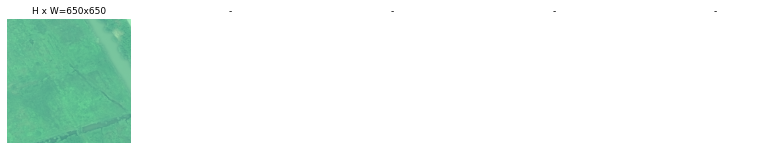

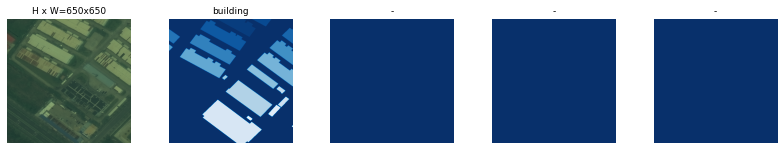

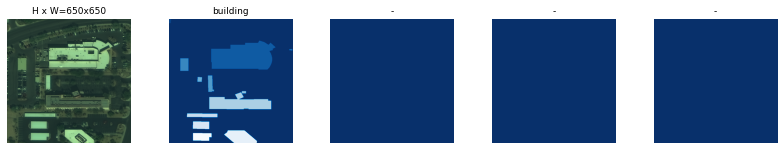

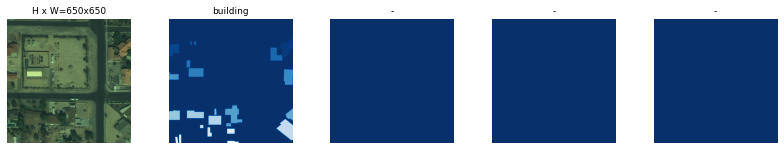

In [8]:
# Load and display random samples
image_ids = np.random.choice(dataset_train.image_ids, 4)
for image_id in image_ids:
    image = dataset_train.load_orig_image(image_id)
    mask, class_ids = dataset_train.load_mask(image_id)
    visualize.display_top_masks(image, mask, class_ids, dataset_train.class_names)

## Create Model

In [9]:
# Create model in training mode
model = modellib.MaskRCNN(mode="training", config=config,
                          model_dir=MODEL_DIR)

In [10]:
# Which weights to start with?
init_with = "coco"  # imagenet, coco, or last

if init_with == "imagenet":
    model.load_weights(model.get_imagenet_weights(), by_name=True)
elif init_with == "coco":
    # Load weights trained on MS COCO, but skip layers that
    # are different due to the different number of classes
    # See README for instructions to download the COCO weights
    model.load_weights(COCO_MODEL_PATH, by_name=True,
                       exclude=["mrcnn_class_logits", "mrcnn_bbox_fc", 
                                "mrcnn_bbox", "mrcnn_mask"])
elif init_with == "last":
    # Load the last model you trained and continue training
    model.load_weights(model.find_last(), by_name=True)

In [ ]:
# Train the head branches
# Passing layers="heads" freezes all layers except the head
# layers. You can also pass a regular expression to select
# which layers to train by name pattern.
model.train(dataset_train, dataset_val, 
            learning_rate=config.LEARNING_RATE, 
            epochs=20, 
            layers='heads',
            max_queue=1, 
            workers=1)


Starting at epoch 0. LR=0.001

Checkpoint Path: /lfs/jonas/maskrcnn/logs/sats20201024T2357/mask_rcnn_sats_{epoch:04d}.h5
Selecting layers to train
fpn_c5p5               (Conv2D)
fpn_c4p4               (Conv2D)
fpn_c3p3               (Conv2D)
fpn_c2p2               (Conv2D)
fpn_p5                 (Conv2D)
fpn_p2                 (Conv2D)
fpn_p3                 (Conv2D)
fpn_p4                 (Conv2D)
rpn_model              (Functional)
mrcnn_mask_conv1       (TimeDistributed)
mrcnn_mask_bn1         (TimeDistributed)
mrcnn_mask_conv2       (TimeDistributed)
mrcnn_mask_bn2         (TimeDistributed)
mrcnn_class_conv1      (TimeDistributed)
mrcnn_class_bn1        (TimeDistributed)
mrcnn_mask_conv3       (TimeDistributed)
mrcnn_mask_bn3         (TimeDistributed)
mrcnn_class_conv2      (TimeDistributed)
mrcnn_class_bn2        (TimeDistributed)
mrcnn_mask_conv4       (TimeDistributed)
mrcnn_mask_bn4         (TimeDistributed)
mrcnn_bbox_fc          (TimeDistributed)
mrcnn_mask_deconv      (Tim

In [ ]:
# Fine tune all layers
# Passing layers="all" trains all layers. You can also 
# pass a regular expression to select which layers to
# train by name pattern.
model.train(dataset_train, dataset_val, 
            learning_rate=config.LEARNING_RATE / 10,
            epochs=75, 
            layers="all",
            max_queue=1, 
            workers=1)

In [ ]:
# Save weights
# Typically not needed because callbacks save after every epoch
# Uncomment to save manually
# model_path = os.path.join(MODEL_DIR, "mask_rcnn_shapes.h5")
# model.keras_model.save_weights(model_path)

In [ ]:
class InferenceConfig(SatsConfig):
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

inference_config = InferenceConfig()

# Recreate the model in inference mode
model = modellib.MaskRCNN(mode="inference", 
                          config=inference_config,
                          model_dir=MODEL_DIR)

# Get path to saved weights
# Either set a specific path or find last trained weights
# model_path = os.path.join(ROOT_DIR, ".h5 file name here")
model_path = model.find_last()

# Load trained weights
print("Loading weights from ", model_path)
model.load_weights(model_path, by_name=True)

In [ ]:
# Test on a random image
image_id = random.choice(dataset_val.image_ids)
stan_image, orig_image, image_meta, gt_class_id, gt_bbox, gt_mask =\
    modellib.load_image_gt(dataset_val, inference_config, 
                           image_id)

log("orig_image", orig_image)
log("image_meta", image_meta)
log("gt_class_id", gt_class_id)
log("gt_bbox", gt_bbox)
log("gt_mask", gt_mask)

visualize.display_instances(orig_image, gt_bbox, gt_mask, gt_class_id, 
                            dataset_train.class_names, figsize=(8, 8))

In [ ]:
results = model.detect([stan_image], verbose=1)

r = results[0]
visualize.display_instances(orig_image, r['rois'], r['masks'], r['class_ids'], 
                            dataset_val.class_names, r['scores'], ax=get_ax())

In [ ]:
# Compute VOC-Style mAP @ IoU=0.5
# Running on 10 images. Increase for better accuracy.
image_ids = np.random.choice(dataset_val.image_ids, 10)
APs = []
for image_id in image_ids:
    # Load image and ground truth data
    stan_image, orig_image, image_meta, gt_class_id, gt_bbox, gt_mask =\
        modellib.load_image_gt(dataset_val, inference_config,
                               image_id)
    molded_images = np.expand_dims(modellib.mold_image(image, inference_config), 0)
    # Run object detection
    results = model.detect([stan_image], verbose=0)
    r = results[0]
    # Compute AP
    AP, precisions, recalls, overlaps =\
        utils.compute_ap(gt_bbox, gt_class_id, gt_mask,
                         r["rois"], r["class_ids"], r["scores"], r['masks'])
    APs.append(AP)
    
print("mAP: ", np.mean(APs))